In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from utils import generator, read_batch
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
p_file_idxes = 'data/file_idxes.npy'
p_tokenizer = 'data/tokenizer.pickle'
p_label2idx = 'data/label2idx.pickle'
p_label_counter = 'data/label_counter'
p_word_vectors = './data/word_vectors.npy'
data_path = './data'

In [3]:
EMBEDDING_DIM = 200

    Read needed for reading variables

In [4]:
file_idxes = np.load(p_file_idxes)
word_vectors = np.load(p_word_vectors)
with open(p_label2idx, 'rb') as f:
    label2idx = pickle.load(f)
with open(p_label_counter, 'rb') as f:
    label_counter = pickle.load(f)
with open(p_tokenizer, 'rb') as f:
    tokenizer = pickle.load(f)

In [5]:
for i, (seq, lab) in enumerate(generator(file_idxes, data_path, label2idx)):
    print(seq, lab)
    if i > 0:
        break

[[ 120  313]
 [   0  394]
 [   0  529]
 [   0 1275]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[293]
 [626]
 [109]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


    Make nn architechture

In [7]:
import tensorflow as tf

In [8]:
def gen():
    for seq, lab in generator(file_idxes, data_path, label2idx):
        seq = word_vectors[seq]
        yield seq, lab

In [9]:
N_FILTERS = 100

In [10]:
def init_variable(shape, name):
    return tf.Variable(tf.initializers.variance_scaling()(shape, tf.float32), name=name)

tf.reset_default_graph()
dataset = tf.data.Dataset.from_generator(
    lambda: generator(file_idxes, data_path, label2idx),
    (tf.int32, tf.float32),
    ((None, None), (None, len(label2idx))))
training = tf.placeholder(tf.bool, shape=[])
it = dataset.make_one_shot_iterator()
embeddings = tf.Variable(word_vectors, trainable=False, dtype=tf.float32)
seqs, labels = it.get_next()
seqs = tf.nn.embedding_lookup(embeddings, seqs)

conv_weights = init_variable([4, 200, N_FILTERS], 'conv_weights')
seqs = tf.nn.conv1d(seqs, conv_weights, 1, 'SAME')
x = tf.reduce_max(seqs, axis=1)
x = tf.layers.batch_normalization(x, training=training)
logits = tf.layers.dense(x, len(label2idx), kernel_initializer=tf.initializers.variance_scaling())
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))

train_step = tf.train.AdamOptimizer().minimize(loss)


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        sess.run(train_step, feed_dict={training:True})

    Check batch_normalization

In [12]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-u

In [13]:
!mkdir models
model_path = './models/model1'

In [14]:
def batch_gen(data, labels, batch_size):
    while True:
        idxes = np.arange(len(data))
        np.random.shuffle(idxes)
        for start_idx in range(0, len(data), batch_size):
            end_idx = min(start_idx + batch_size, len(data))
            yield data[start_idx : end_idx], labels[start_idx : end_idx]

In [15]:
tg = batch_gen(train_data, train_labels, 32)

In [16]:
next(tg)[1].shape

(32,)

In [37]:
tf.reset_default_graph()
image = tf.placeholder(tf.float32, [None, 784])
labels = tf.placeholder(tf.int64, [None])
training = tf.placeholder(tf.bool, [])

with tf.name_scope('batch_normed'):
    x_bn = tf.layers.dense(image, 100, activation=tf.nn.relu, use_bias=True)
    x_bn = tf.layers.dense(x_bn, 100, activation=tf.nn.relu, use_bias=False)
    x_bn = tf.layers.batch_normalization(x_bn, training=training)
    logits_bn = tf.layers.dense(x_bn, 10)
    loss_bn = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_bn))
    accuracy_bn = tf.reduce_mean(tf.cast(tf.equal(labels, tf.argmax(logits_bn, axis=1)), tf.float32))
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op_bn = tf.train.AdamOptimizer(1e-2).minimize(loss_bn)
        
with tf.name_scope('not_normed'):
    x_nbn = tf.layers.dense(image, 100, activation=tf.nn.relu, use_bias=True)
    x_nbn = tf.layers.dense(x_nbn, 100, activation=tf.nn.relu, use_bias=True)
    logits_nbn = tf.layers.dense(x_nbn, 10)
    loss_nbn = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_nbn))
    accuracy_nbn = tf.reduce_mean(tf.cast(tf.equal(labels, tf.argmax(logits_nbn, axis=1)), tf.float32))
    
    train_op_nbn = tf.train.AdamOptimizer(1e-2).minimize(loss_nbn)


In [38]:
saver = tf.train.Saver(max_to_keep=2)

In [39]:
%%time

tn_losses_bn = []
eval_losses_bn = []
tn_losses_nbn = []
eval_losses_nbn = []

tn_accs_bn = []
eval_accs_bn = []
tn_accs_nbn = []
eval_accs_nbn = []

fake_eval_accs_bn = []
fake_eval_losses_bn = []
fake_eval_accs_nbn = []
fake_eval_losses_nbn = []

train_gen = batch_gen(train_data, train_labels, 60)
eval_gen = batch_gen(eval_data, eval_labels, 100)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in tqdm_notebook(range(1, 10001)):
        batch_x, batch_y = next(train_gen)
        _, _, lbn, lnbn, abn, anbn = sess.run(
            [train_op_bn, train_op_nbn, loss_bn, loss_nbn, accuracy_bn, accuracy_nbn],
            feed_dict={
                image: batch_x,
                labels: batch_y,
                training: True
            }
        )
        tn_losses_bn.append(lbn)
        tn_losses_nbn.append(lnbn)
        tn_accs_bn.append(abn)
        tn_accs_nbn.append(anbn)
        
        if i % 500 == 0:
            saver.save(sess, model_path)
            
            full_loss_bn, full_right_bn = 0, 0
            full_loss_nbn, full_right_nbn = 0, 0
            fake_full_loss_bn, fake_full_right_bn = 0, 0
            
            for _ in range(100):
                batch_x, batch_y = next(eval_gen)
                lbn, lnbn, abn, anbn = sess.run([loss_bn, loss_nbn, accuracy_bn, accuracy_nbn], feed_dict={
                    image: batch_x,
                    labels: batch_y,
                    training: False
                })
                
                full_loss_bn += lbn
                full_right_bn += 100 * abn
                
                full_loss_nbn += lnbn
                full_right_nbn += 100 * anbn
                
                lbn, abn = sess.run([loss_bn, accuracy_bn], feed_dict={
                    image: batch_x,
                    labels: batch_y,
                    training: True
                })
                
                fake_full_loss_bn += lbn
                fake_full_right_bn += 100 * abn
                
            eval_losses_bn.append(full_loss_bn / 100)
            eval_losses_nbn.append(full_loss_nbn / 100)
            eval_accs_bn.append(full_right_bn / 10000)
            eval_accs_nbn.append(full_right_nbn / 10000)
            
            fake_eval_accs_bn.append(fake_full_loss_bn / 100)
            fake_eval_losses_bn.append(fake_full_right_bn / 10000)


CPU times: user 1min 8s, sys: 12.5 s, total: 1min 20s
Wall time: 24.7 s


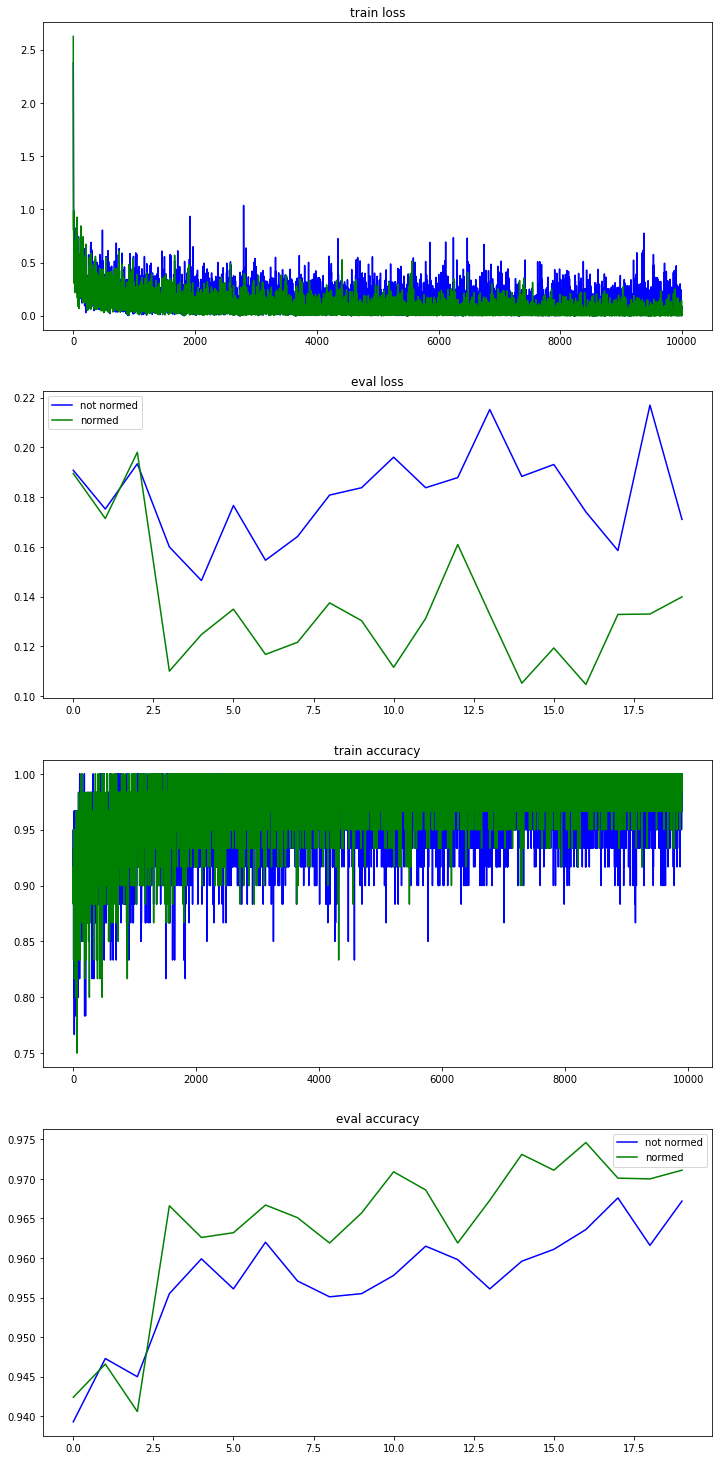

In [43]:
fig, axes = plt.subplots(4, figsize=[12, 26])

axes[0].set_title('train loss')
axes[0].plot(tn_losses_nbn, c='b')
axes[0].plot(tn_losses_bn, c='g')

axes[1].set_title('eval loss')
axes[1].plot(eval_losses_nbn, c='b', label='not normed')
axes[1].plot(eval_losses_bn, c='g', label='normed')
# axes[1].plot(fake_eval_losses_bn, c='r', label='normed badly')
axes[1].legend()

axes[2].set_title('train accuracy')
axes[2].plot(tn_accs_nbn[100:], c='b')
axes[2].plot(tn_accs_bn[100:], c='g')

axes[3].set_title('eval accuracy')
axes[3].plot(eval_accs_nbn, c='b', label='not normed')
axes[3].plot(eval_accs_bn, c='g', label='normed')
# axes[3].plot(fake_eval_accs_bn, c='r', label='normed badly')
axes[3].legend()


    Check model saving and restoring

In [25]:
! rm models/*

In [26]:
tf.reset_default_graph()
p = tf.placeholder(tf.float32, shape=[], name='p')
var_a = tf.Variable(0, dtype=tf.float32, name='a')
var_b = tf.Variable(1, dtype=tf.float32, name='b')
var_a = tf.assign(var_a, var_a + var_b)
var_c = tf.add(p, var_b, name='c')
saver = tf.train.Saver(max_to_keep=3)

In [27]:
test_model_path = 'models/test_model'

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        print(sess.run([var_a, var_c], feed_dict={p:1}))
        print(saver.save(sess, test_model_path, write_meta_graph=True, global_step=i))

[1.0, 2.0]
models/test_model-0
[2.0, 2.0]
models/test_model-1
[3.0, 2.0]
models/test_model-2
[4.0, 2.0]
models/test_model-3
[5.0, 2.0]
models/test_model-4
[6.0, 2.0]
models/test_model-5
[7.0, 2.0]
models/test_model-6
[8.0, 2.0]
models/test_model-7
[9.0, 2.0]
models/test_model-8
[10.0, 2.0]
models/test_model-9


In [29]:
! ls -lh models/

total 80
-rw-r--r--  1 mzmeev  staff   167B May 17 13:21 checkpoint
-rw-r--r--  1 mzmeev  staff     8B May 17 13:21 test_model-7.data-00000-of-00001
-rw-r--r--  1 mzmeev  staff   134B May 17 13:21 test_model-7.index
-rw-r--r--  1 mzmeev  staff   3.4K May 17 13:21 test_model-7.meta
-rw-r--r--  1 mzmeev  staff     8B May 17 13:21 test_model-8.data-00000-of-00001
-rw-r--r--  1 mzmeev  staff   134B May 17 13:21 test_model-8.index
-rw-r--r--  1 mzmeev  staff   3.4K May 17 13:21 test_model-8.meta
-rw-r--r--  1 mzmeev  staff     8B May 17 13:21 test_model-9.data-00000-of-00001
-rw-r--r--  1 mzmeev  staff   134B May 17 13:21 test_model-9.index
-rw-r--r--  1 mzmeev  staff   3.4K May 17 13:21 test_model-9.meta


In [30]:
tf.reset_default_graph()
sess = tf.Session()
loader = tf.train.import_meta_graph(test_model_path + '-9.meta')
loader.restore(sess, test_model_path + '-9')
graph = tf.get_default_graph()
graph.get_all_collection_keys()
graph.get_collection('variables')

print([
    sess.run(graph.get_tensor_by_name('c:0'), {graph.get_tensor_by_name('p:0'): 3}),
    sess.run(graph.get_tensor_by_name('a:0'))
])
loader.restore(sess, test_model_path + '-7')
print([
    sess.run(graph.get_tensor_by_name('c:0'), {graph.get_tensor_by_name('p:0'): 3}),
    sess.run(graph.get_tensor_by_name('a:0'))
])
sess.close()

INFO:tensorflow:Restoring parameters from models/test_model-9
[4.0, 10.0]
INFO:tensorflow:Restoring parameters from models/test_model-7
[4.0, 8.0]


In [31]:
import json

In [32]:
with open('../Downloads/Task6a-Batch1-Week1_raw.json', 'r') as f:
    file = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../Downloads/Task6a-Batch1-Week1_raw.json'

In [33]:
len(file['documents'])

NameError: name 'file' is not defined

In [34]:
t = file['documents'][0]['title'] + file['documents'][0]['abstractText']

NameError: name 'file' is not defined

In [35]:
word_vectors[np.array(tokenizer.tokenize(t))]

NameError: name 't' is not defined